# 卷積網絡(convnets)模型學習到什麼的可視化

注意: 這篇文章的內容需要一些Keras的理解, 這先確認你/妳己先閱讀並練習過以下的連結內容:
* [1.4-small-datasets-image-augmentation](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.4-small-datasets-image-augmentation.ipynb)

* [1.5-use-pretrained-model-2](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.5-use-pretrained-model-2.ipynb)

常聽人說，深度學習的模型是個"黑盒子"，非常難以讓人類容易了解的方法來呈現這個模型到底學到了什麼。雖然這樣的說法對於某些類型的深度學習模型是的真實，但對於卷積網絡(convnets)模型來說絕對不是這樣。

卷積網絡(convnets)模型所學習到特徵非常適合用視覺化的方法來呈現，它在很大程度上是因為卷積網絡本來就是視覺概念的陳述。自2013年以來，已經開發了各種各樣的技術，可用於可視化和解釋這些表示。我們不會說明所有方法，但我們將包含三個最容易使用和有用的部份來進行視覺化的展現：

* `中間神經層的輸出（“中間層激勵結果”）`- 這有助於了解連續的卷積網絡(convnets)層如何轉換其輸入，我們可以獲得每一個convnet過濾器的含義與結果。

* `卷積過濾器(convnets filters)`- 這有助於準確地了解每個過濾器在什麼樣的視覺模式或概念中起作用。

* `圖像中各類別被激勵後的熱力圖`- 這對於了解被識別為屬於某特定類別的圖像的哪個區域是有特別有效的。

對於第一種方法: 激勵的可視化(activation visualization) - 我們將使用我們對貓與狗分類問題從頭開始訓練起的小型卷積網絡(convnets)模型。至於其它的兩種方法，我們將使用上一節中介紹的VGG16模型。

![conv-visualization](https://cdn-images-1.medium.com/max/800/1*SRXEQsEDUJbJH-VYHLF_lA.png)

In [1]:
# 這個Jupyter Notebook的環境
import warnings
warnings.filterwarnings('ignore')

import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

Using TensorFlow backend.


Platform: Windows-10-10.0.17763-SP0
Tensorflow version: 1.3.0
Keras version: 2.2.0


## 資料集說明 & 資料準備

這一篇文章的內容會延用[[1.5-use-pretrained-model-2](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.5-use-pretrained-model-2.ipynb)]的資料及過程中所產出的模型檔。請把本jupyter notebook置放在[[1.5-use-pretrained-model-2](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.5-use-pretrained-model-2.ipynb)]的同一個目錄裡:

最後你的目錄結構看起來像這樣:
```
1.5-use-pretrained-model-2.ipynb
1.6-visualizing-what-convnets-learn.ipynb
cats_and_dogs_small_2.h5
data/
├── train/
|   ├── cat.0.jpg
|   ├── cat.1.jpg
|   ├── ..
|   └── dog.12499.jpg
└── cats_and_dogs_small/
    ├── test/
    ├── train/
    └── validation/
```

## 1. 中間神經層輸出的視覺化

中間層激勵(intermediate activations)結東的可視化包括顯示由網絡中的各種卷積和池化層輸出的特徵圖(feature maps)，給定一定的輸入（層的輸出通常稱為`激勵`，也就是神經元經過激勵函數後的輸出）。

這樣可以看出輸入如何被分解到由網絡學到的不同過濾器。我們想要可視化的這些特徵圖(feature maps)具有三個維度：寬度，高度和深度（圖像通道）。每個通道編碼出相對獨立的特徵，所以可視化這些特徵圖的正確方法是通過獨立繪製每個通道的內容作為2D圖像。

我們會載入我們在路[[1.4-small-datasets-image-augmentation](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.4-small-datasets-image-augmentation.ipynb)]的運行過程中保存下來的模型：`cats_and_dogs_small_2.h5`

In [2]:
from keras.models import load_model

# 加載保存的模型：
model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # 打印模型

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

我們將使用一個未被模型看過的圖像作為輸入(一個貓的圖片，它不是網絡訓練資料集的一部分)：

In [3]:
img_path = 'data/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 我們把圖像轉換成網絡要求的張量shape (4D 張量)
# (樣本數, 圖像高度, 圖像寬度, 圖像通道)
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150)) # 載入圖像並轉換大小為150x150
img_tensor = image.img_to_array(img) # 把影像物件轉換成 numpy ndarray物件

print("Origin img_tensor shape: ", img_tensor.shape)

img_tensor = np.expand_dims(img_tensor, axis=0) # 多增加一個維度來符合Keras Conv2D的要求

print("After reshape img_tensor shape: ", img_tensor.shape)

# 這個模型的輸入是有經過歸一化的前處理
# 所以我們也要進行相同的前處理
img_tensor /= 255. # 進行資料尺度(scale)的轉換

Origin img_tensor shape:  (150, 150, 3)
After reshape img_tensor shape:  (1, 150, 150, 3)


讓我們展示一下圖像:

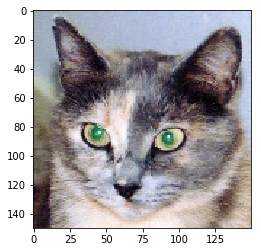

In [4]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

為了提取要查看的特徵圖(feature map)，我們將創建一個Keras模型，來將圖像作為輸入，並輸出所有經過卷積層和池化層的激勵輸出結果。

為了這個目的，我們將使用Keras類別`Model`。一個`Model`的實例化需要兩個參數：輸入張量（或輸入張量列表）以及輸出張量（或輸出張量列表）。

所得到的類別是一個Keras模型(model)物件，就像你熟悉的`Sequential`模型，我們將指定的輸入映射到指定的輸出。 `Model`類別的區別在於它允許具有多個輸出的模型，與`Sequential`不同。

有關`Model`類別的更多信息，請參見[[1.1-keras-functional-api](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.1-keras-functional-api.ipynb)]。

In [5]:
from keras import models

# 創建一個list來儲存前8層處理後的outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# 產生一個model物件, 它的input是原先模型的input, 而它的output則是前8層處理後的outputs
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

layer_outputs # 看一下物件的結構

[<tf.Tensor 'conv2d_5/Relu:0' shape=(?, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_5/MaxPool:0' shape=(?, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_6/Relu:0' shape=(?, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_6/MaxPool:0' shape=(?, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_7/Relu:0' shape=(?, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_7/MaxPool:0' shape=(?, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_8/Relu:0' shape=(?, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_8/MaxPool:0' shape=(?, 7, 7, 128) dtype=float32>]

當我們將圖像餵進這個模型時，此模型會返回原始模型中特定層被激勵函數處理過後的值。

這是一個多輸出的模型：在此之前，一般你看到的模型都只有一個輸入和一個輸出。在一般情況下，模型可以具有任意數量的輸入和輸出。而這個範例有1個輸入和8個輸出，每一層的激勵結果變成一個輸出。

In [6]:
# 透過model.predict()的處理, model將會回傳一個有8個神經層處理後的output的列表:
activations = activation_model.predict(img_tensor)

len(activations) # 讓我們確認一下產生的數量

8

例如，以下是我們的貓圖像輸入的第一個卷積層的激勵輸出：

In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape) # 看一下第一層產生的shape

(1, 148, 148, 32)


這是一個具有32個頻道的148x148特徵圖(feature map)。讓我們來看看第3個頻道的圖像：

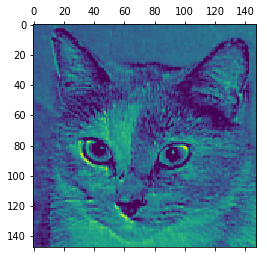

In [8]:
import matplotlib.pyplot as plt
# 秀出第3個頻導的特徵圖
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

該通道似乎可以視為對角邊緣的編碼檢測器。讓我們嘗試第30個頻道 - 但請注意，您自己的頻道可能會有所不同，因為卷積層學習的特定濾鏡不是確定性的( not deterministic)。

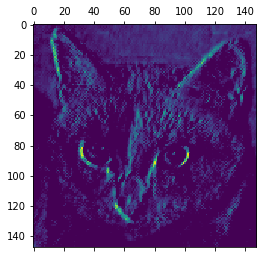

In [9]:
# 秀出第30個頻導的特徵圖
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

這個看起來像是一個“明亮的綠點”的檢測器，可以用來編碼貓的眼睛。在這一時間點上，讓我們去繪製網絡中所有激勵輪出的完整可視化。我們將提取和繪製每個8個特徵圖(feature maps)中的每個通道，並將結果疊加在一個大圖像張量中，排排站一起列出來。

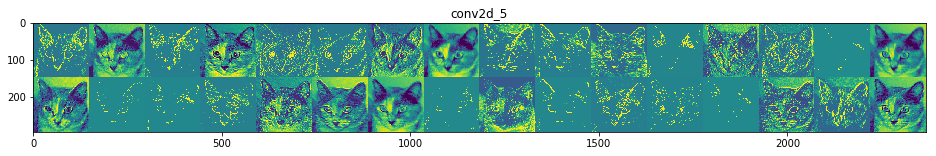

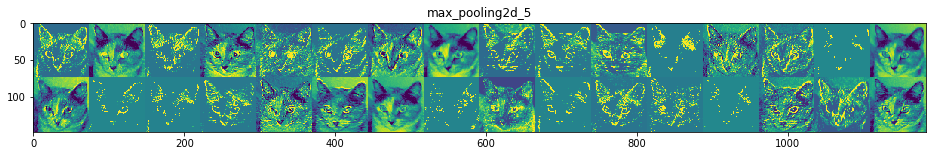

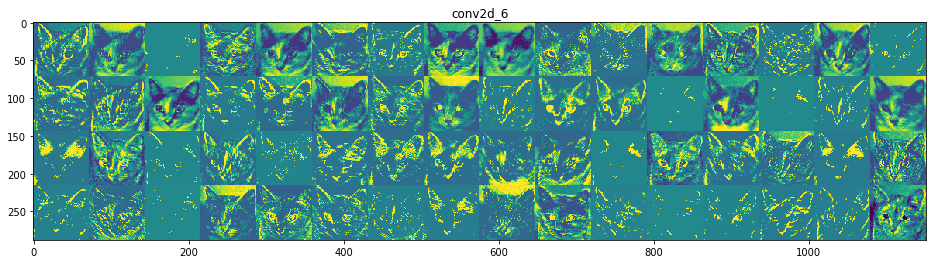

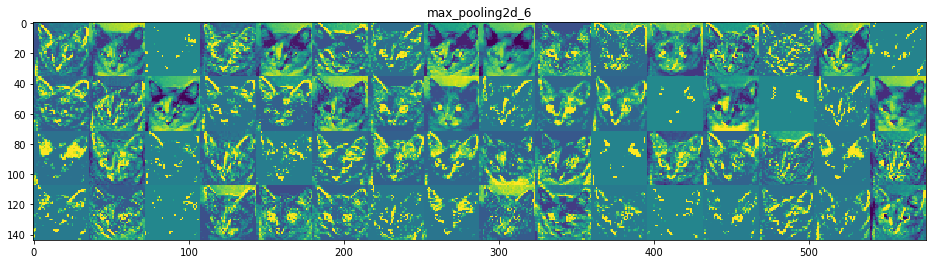

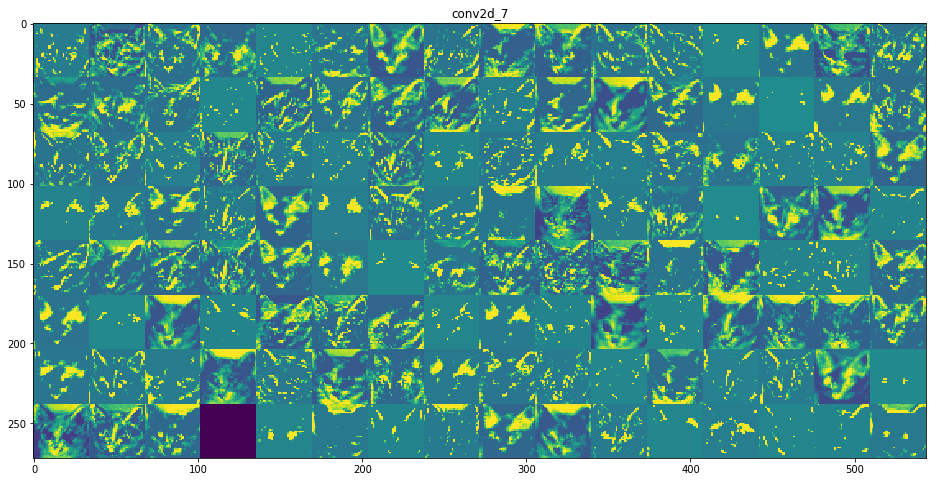

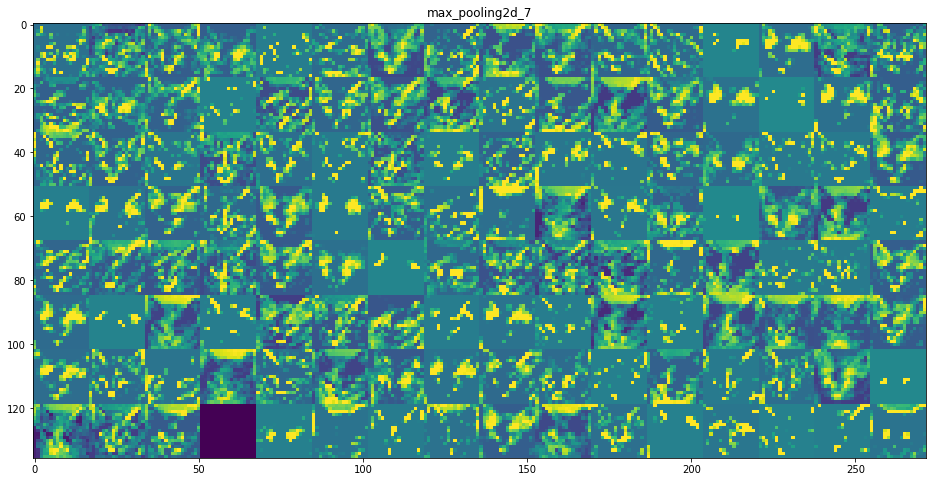

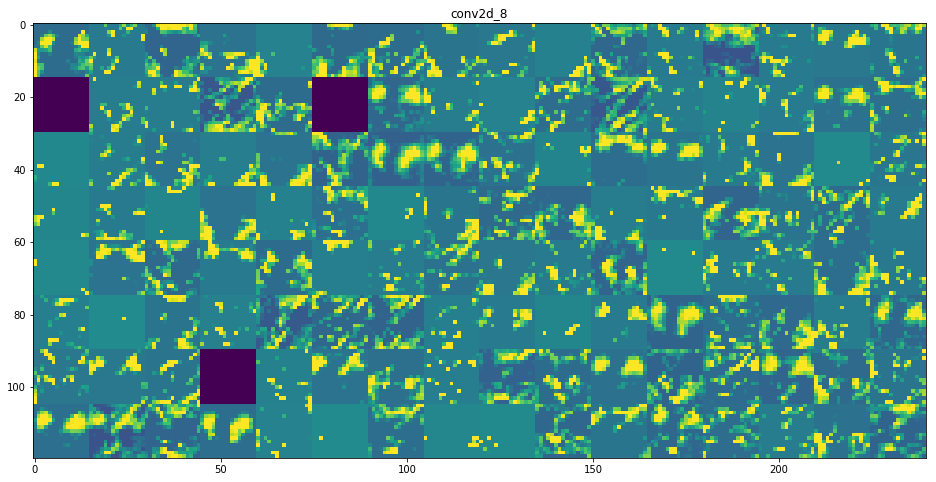

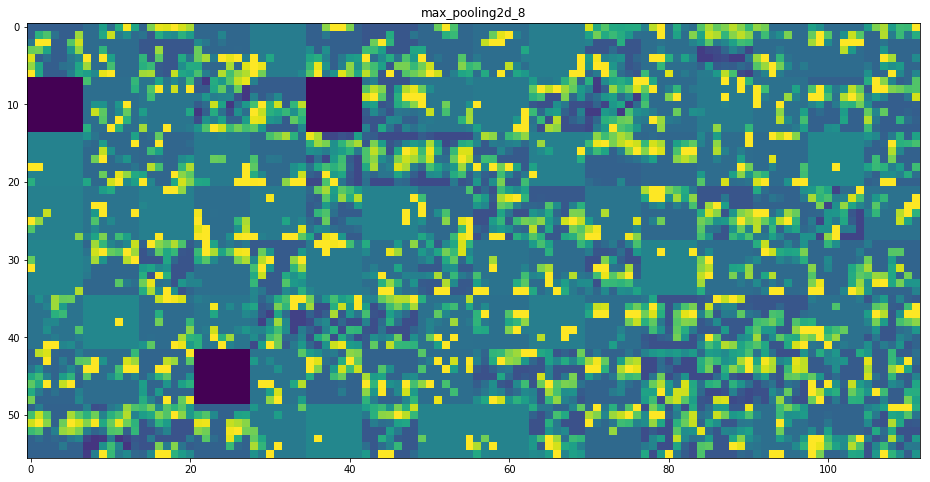

In [10]:
import keras

# 每一層的神經層都有它的名字, 我們可以跟著打印出來
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16 # 每一排打印16個特徵圖

# 每一層特徵圖的Shapes
# layer#01 -> (148, 148, 32)
# layer#02 -> (74, 74, 32)
# layer#03 -> (72, 72, 64)
# layer#04 -> (36, 36, 64)
# layer#05 -> (34, 34, 128)
# layer#06 -> (17, 17, 128)
# layer#07 -> (15, 15, 128)
# layer#08 -> (7, 7, 128)

# 讓我們打印出我們的特徵圖
for layer_name, layer_activation in zip(layer_names, activations): # 我們有8層的神經元的輸出
  
    n_features = layer_activation.shape[-1] # 取得每一層特徵圖的數量

    
    size = layer_activation.shape[1] # 取得每一個特徵圖的寬與高 (1, size, size, n_features)

    # 我們會把多個特徵圖串接在一個比較大的矩陣
    n_cols = n_features // images_per_row # 算一下這個大矩陣的會有幾欄
    display_grid = np.zeros((size * n_cols, images_per_row * size)) # 產生一個大矩陣
   
    # 我們會把每一個特徵圖像是磁磚一樣拼貼在一起
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 展示拼貼出來的結果
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

這裡有一些值得関注的事情要請大家注意:

* 第一層就像是各種邊緣檢測器的集合。在這個階段，激勵後的結果仍然保留了原始圖片中幾乎所有的信息。

* 隨著我們層數越來越高，激勵後的結果變得越來越抽象，視覺上的解釋也越來越少。他們開始編碼出更高層次的概念，如“貓耳朵”或“貓眼”。更高層的特徵表示(representation)對用圖像的方法來進行視覺化可被人類感知的信息越來越少，但是卻開始產生越來越多圖像類別有關的信息。

* 激勵結果的稀疏度隨著層數的深度而增加：在第一層中，所有過濾器都被輸入圖像所激勵，但在愈後面的層中則有越來越多的過濾器結果為空白。這意味著在輸入圖像中找不到過濾器所認知的特徵。

我們剛剛證明了深度神經網絡一個非常重要的特質：隨著神經層的深度愈來愈深由該層提取的特徵也越來越抽象。關於被看到的具體輸入的信息在愈高層次的激勵傳遞會越來越少，關於目標類別（在我們的範例中，圖像的類別：貓或狗）的的信息則越來越多。

深度神經網絡有效地作為__信息蒸餾管道__，原始數據進入(在我們的例子中是RGB圖片)，並且被重複變換，以便不相關的信息被過濾掉(例如圖像的特定視覺外觀)，同時有用的信息被放大和純化(例如圖像的類別)。

這類似於人類和動物對世界的看法：在觀察了幾秒鐘的場景之後，人類可以記住那些抽象的物品（例如自行車，樹），但是不能記住這些物品的具體外觀。事實上，即使你在一生中看過數以千計的自行車，如果現在要你直接繪製出一個簡單的自行車，你甚至無法畫的出來。

現在嘗試：這個效果是絕對真實的。您的大腦已經學會對對進入我們視野的物品進行抽象化，將其轉換為高級視覺概念，同時過濾掉不相關的視覺細節，這使我們難以記住我們周圍的事物真實的外觀。

## 2. 卷積過濾器的視覺化

檢查卷積網絡所學習到的過濾器的另一個簡單方法是透過顯示每個過濾器回應輸入的視覺模式。這可以通過__輸入空間的gradient__來完成：將__gradient descent__應用到一個卷積網絡輸入圖像的值，以便從空白輸入圖像開始，最大化特定過濾器的回應。所得到的輸入圖像將是所選過濾器最大程度地回應。

這個過程很簡單：我們將建立一個損失函數(loss function)，指定特定卷積層來讓特定過濾器的值最大化，然後我們將使用隨機梯度下降來調整輸入圖像的值，以便最大化這個激勵結果。

例如，這是一個對於在ImageNet上預先訓練的VGG16網絡層“block3_conv1”中的第0個過濾器的激勵的損失函數(loss function):

In [11]:
from keras.applications import VGG16
from keras import backend as K

# 使用VGG16這個預訓練好的模型
model = VGG16(weights='imagenet', include_top=False)

# 打印一下VGG16網絡模型結構圖
model.summary()

# 找出'block3_conv1'這一層的模型
layer_name = 'block3_conv1'
filter_index = 0

# 取得某特定層的output
layer_output = model.get_layer(layer_name).output

# 設計一個損失函數(loss function)
loss = K.mean(layer_output[:, :, :, filter_index])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

為了實現梯度下降，我們將需要相對於模型輸入的這種損失的梯度。為此，我們將使用隨著Keras的`backend`模組一起打包的`gradients`函數:

In [12]:
# 呼叫 `gradients` 方法會回傳一個列表的 tensors (在這個範例: size為1)
grads = K.gradients(loss, model.input)[0]

用於梯度下降過程的一個非常好用技巧是順利地將梯度張量標準化，藉由除以它的L2範數(張量值Root Mean Square，縮寫為RMS)。這確保了對輸入圖像的更新的大小總是在相同的範圍內。

In [13]:
# 為避免除數為0而導致問題我們加了一個很小的數字到除數
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

現在我們需要一種方法來計算給出輸入圖像後損失張量和梯度張量的值。我們可以定義一個Keras後端函數：`iterate`是一個函數，它採用Numpy張量（作為1的張量列表），並返回兩個Numpy張量的列表：損失值和梯度值。

In [14]:
iterate = K.function([model.input], [loss, grads])

# 讓我們測試一下
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

我們可以定義一個Python的迴圈來進行隨機梯度下降(stochastic gradient descent)：

In [15]:
# 讓我們從一個灰階圖像(加了一點燥點)開始
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 跑40次的gradient ascent
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # 計算loss與gradient值
    loss_value, grads_value = iterate([input_img_data])
    # 我們調整輸入的圖像來最大化loss
    input_img_data += grads_value * step

所得到的圖像張量將是形`（1, 150, 150, 3）`的浮點張量，其值可能不在`[0, 255]`內的整數。因此，我們需要對這個張量進行後處理，將其轉換成可顯示的圖像。我們用以下簡單的工具函數來做：

In [16]:
def deprocess_image(x):
    # 張量常態化: center為0., 並且確保std為0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # 轉換為RGB陣列
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

現在我們有了所有需要的零件，讓我們把它們組起來成為一個Python函數，它將輸入一個圖層名稱和一個過濾器索引，並返回一個有效的圖像張量，表示某特定過濾器的最大化激勵模式的輸出:

In [17]:
def generate_pattern(layer_name, filter_index, size=150):
    # 建立一個loss function來最大化激勵的結果
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 計算gradient
    grads = K.gradients(loss, model.input)[0]

    # 我們常態化gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 這個方法回傳某特定圖像的loss與 grads
    iterate = K.function([model.input], [loss, grads])
    
    # 讓我們從一個灰階圖像(加了一點燥點)開始
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 跑40次的gradient ascent
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

我們來試一下：

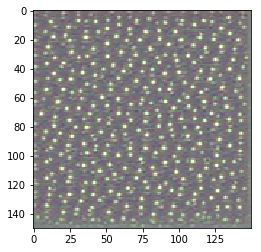

In [18]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

看來，`block3_conv1`層中的這個過濾器對圓點圖案有反應。

另外一個很有趣地方：我們可以開始在每一層的每一個過濾器上進行可視化。為了簡單起見，我們將僅查看每個層中的前64個過濾器，並且只會查看每個卷積組別裡頭第一層（block1_conv1，block2_conv1，block3_conv1，block4_conv1，block5_conv1）。我們將在8x8網格上將每一個64x64濾鏡圖案排排站地輸出(每個濾鏡圖案之間有一些黑邊來做區隔)。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


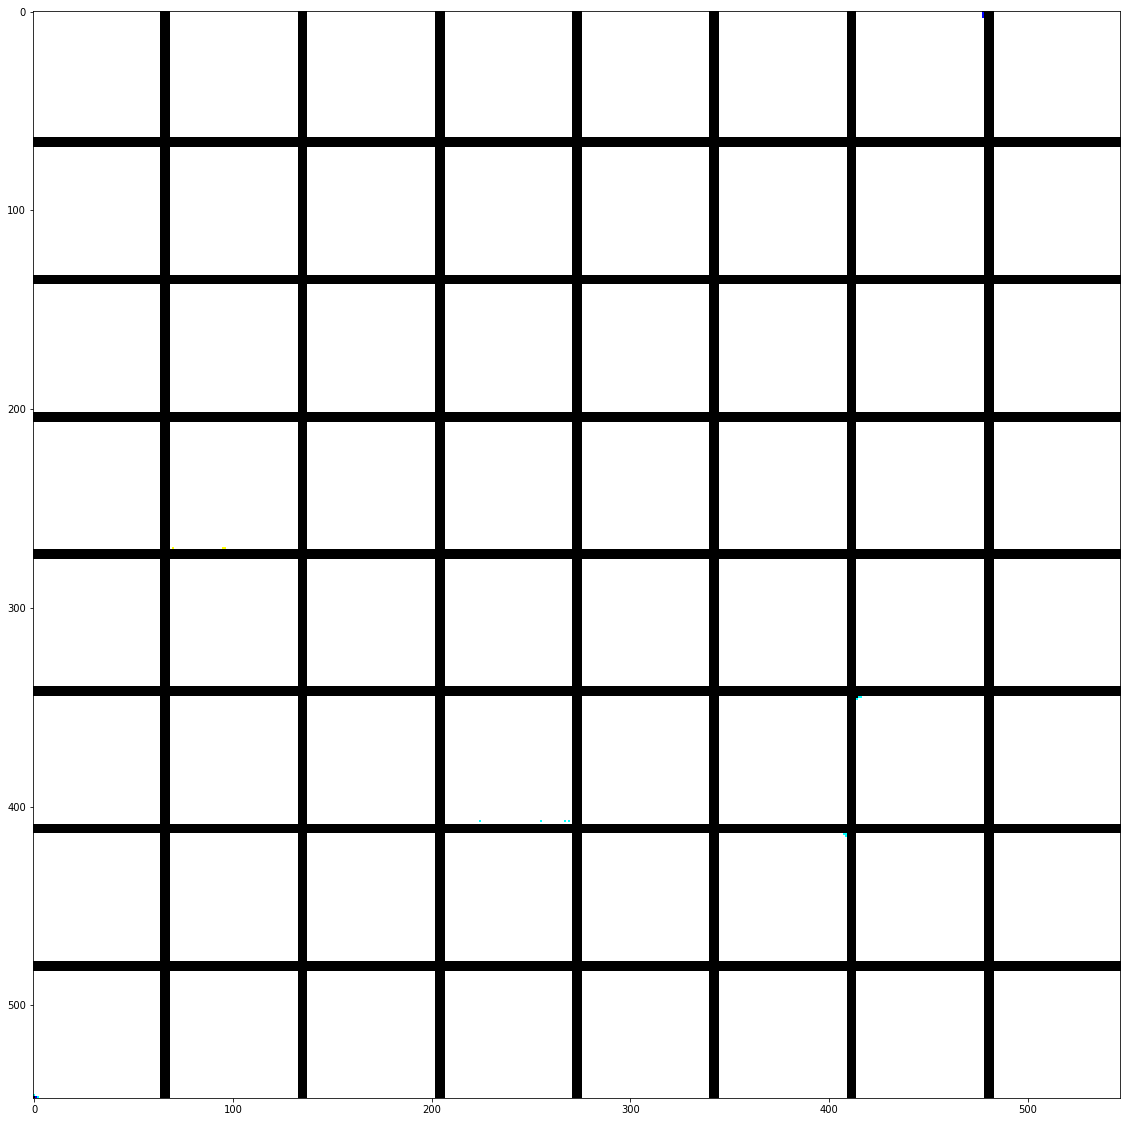

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


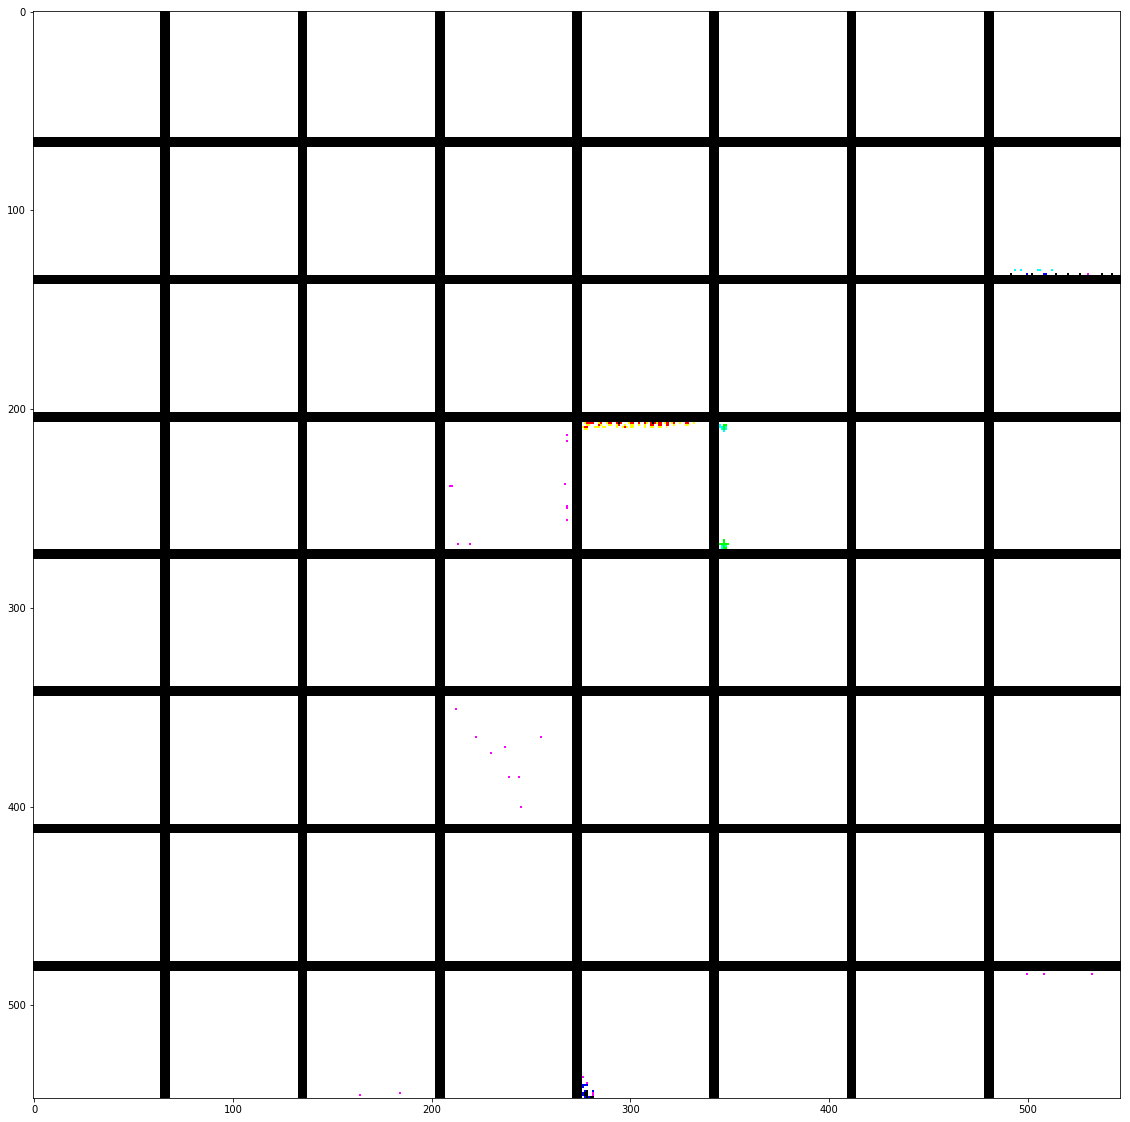

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


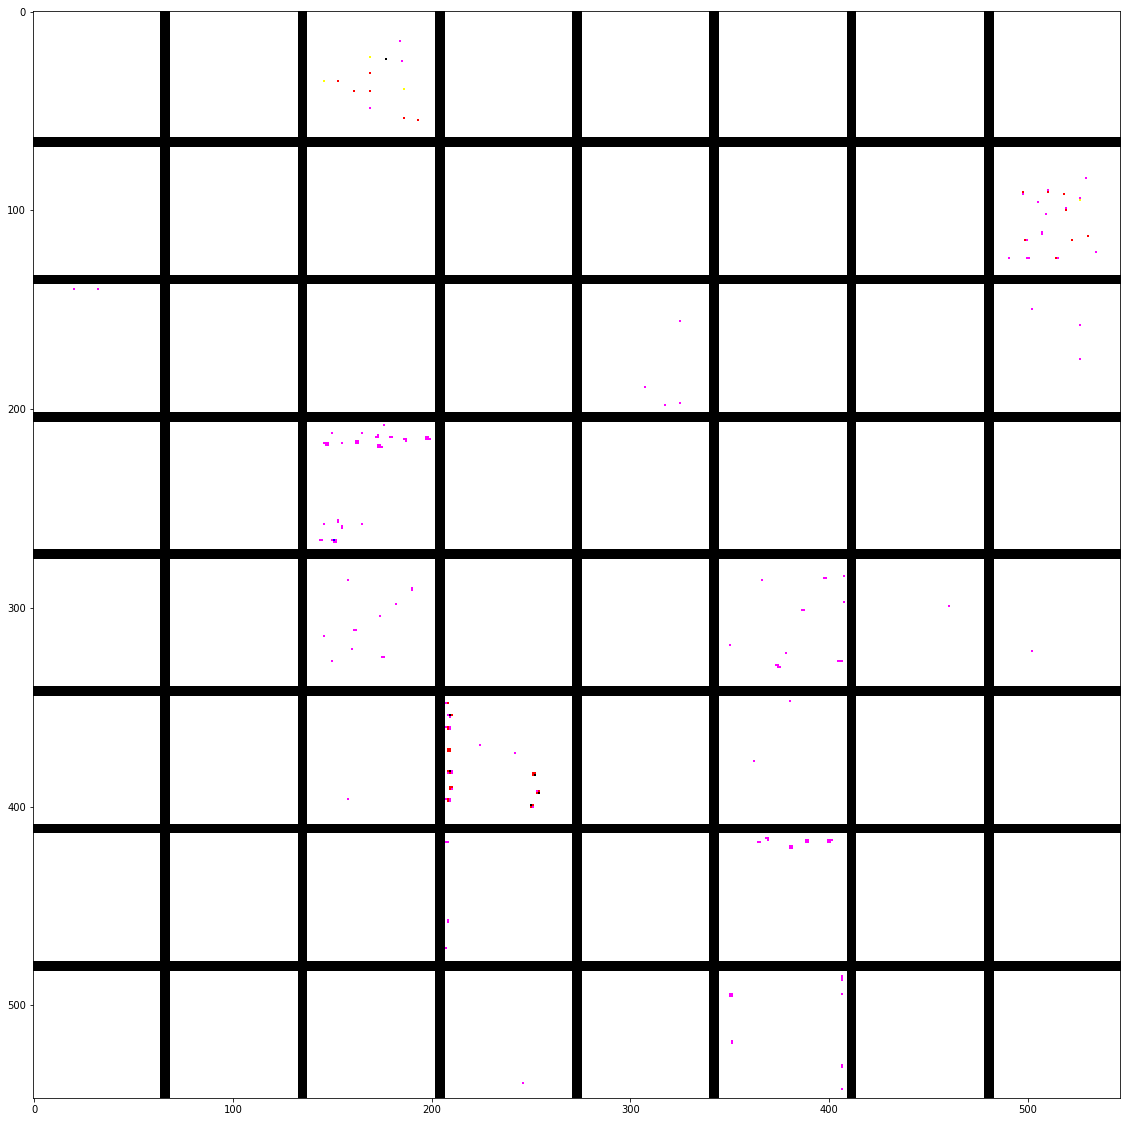

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


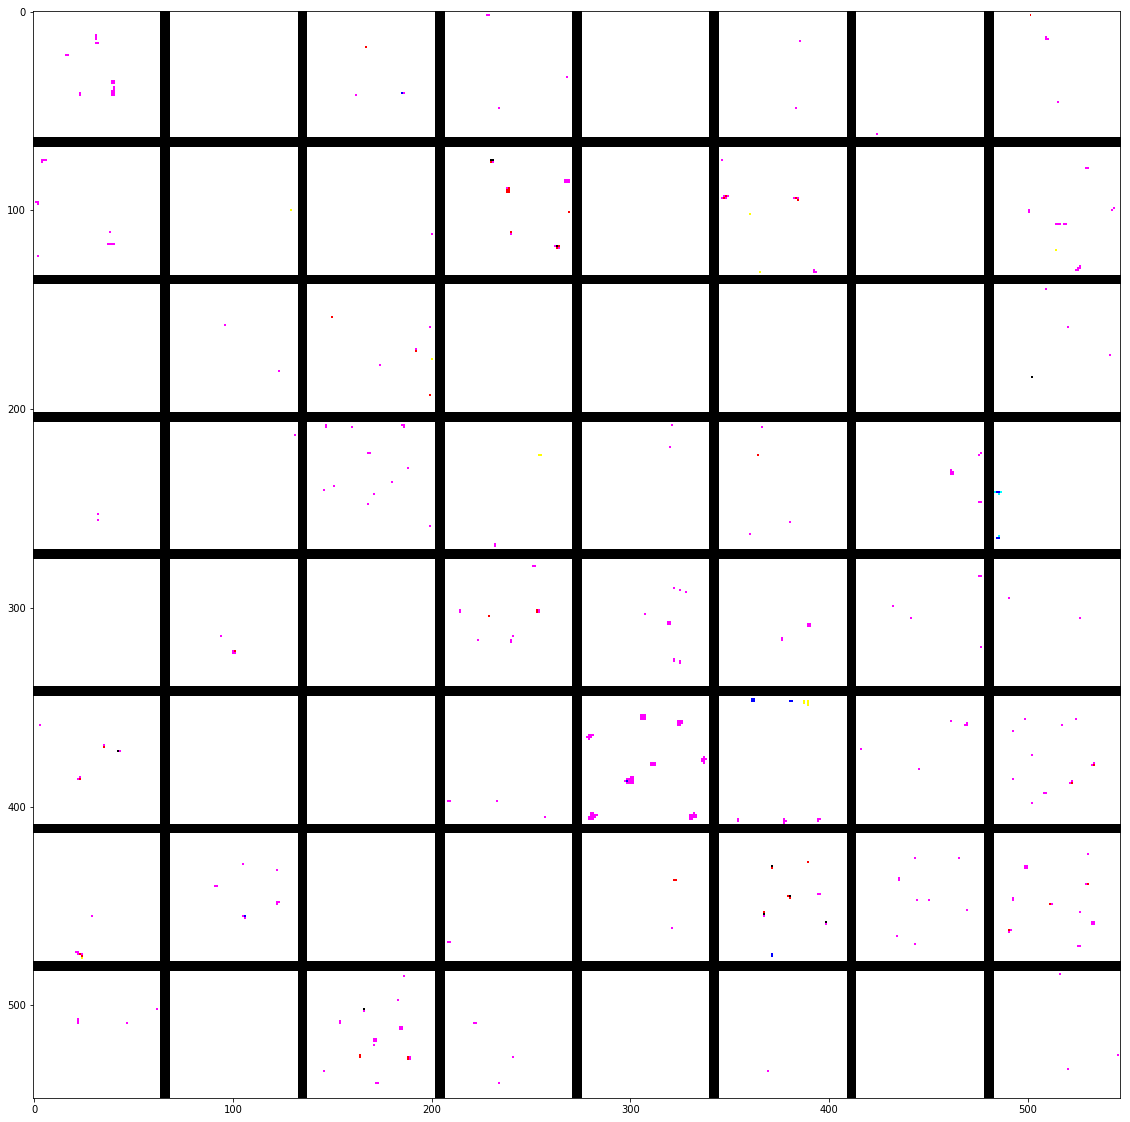

In [19]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 用來拼接結果空間
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # 展示結果
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

這些過濾器可視化的結果告訴我們很多關於卷積網絡(convnets)的每一層如何看到世界：一個卷積網絡(convnets)中的每個層都只是去學習一個過濾器的集合，使得它們的輸入可以表示為過濾器的組合。這類似於傅里葉轉換(Fourier transform)如何將信號分解成一組餘弦函數(cosine functions)。隨著我們在模型的層級越來越高，這些過濾器也越來越複雜和精細化：

* 模型中第一層的過濾器（`block1_conv1`）編碼簡單的偵測邊緣的方向和顏色（有些情況下是彩色邊）。

* `block2_conv1`的過濾器編碼由邊緣和顏色的組合構成的簡單紋理。

* 愈上層的過濾器開始類似於自然圖像中的紋理:比如羽毛, 眼睛, 葉子等。

## 3. 類別激勵熱力圖的視覺化

我們將介紹的一種可視化技術，,它是一種有助於理解特定圖像的哪些部分會是決定最後分類的關鍵。這有助於`調試`一個卷積網絡(convnets)的決策過程，特別是在分類錯誤的情況下。

它還允許你去定位圖像中的特定對象或物件。

這種技術一般會被稱為“類別激勵映射(Class Activation Map)”（CAM）可視化，並且包括在輸入圖像上產生`類別激勵`的熱力圖。 `類別激勵熱力圖`是與特定輸出類相關聯2D分數網格，它針對任何輸入圖像中的每個位置來進行計算，並指示出每個位置相對於所考慮的類別有多大的影響力。例如，給我們的圖像進入我們的“貓與狗”的卷積網絡，`類別激勵熱力圖`可視化允許我們為“貓”的圖像輸入生成熱力圖並且指示圖像中貓的不同部分的影響度，以及同樣的對於“狗”圖像的輸入來指示圖像中狗的不同部分的影響度有什麼差別。

我們將使用的具體實現是[Grad-CAM中描述的：為什麼你這麼說？深度網絡通過基於梯度的本地化的視覺說明](https://arxiv.org/abs/1610.02391)。這種方法非常簡單：它包括給出輸入圖像的卷積層的輸出特徵圖，並且透過類別在不同通道的梯度對該特徵圖中的每個通道進行測量。直覺上，理解這個竅門的一個方法是，我們正在對“輸入圖像激活不同頻道的強度”進行加權的空間映射(spatial map)，也就是“每個通道對於該類別有多重要”。

我們將再次使用預先訓練的VGG16網絡演示此技術：

In [20]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# 注意: 我們這次的模型也會包括VGG的後半段分類器的部份網絡(denbsely-connected)
model = VGG16(weights='imagenet')

TypeError: softmax() got an unexpected keyword argument 'axis'

讓我們考慮以下包括了兩隻非洲大象的圖像，圖像上有一隻大象與小象漫步在熱帶草原:

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

讓我們將這個圖像轉換成VGG16模型可以讀取的內容: 該模型是針對大小為224x224像素的圖像進行預訓練的模型。為有能夠有效地使用VGG16模型, 我們將根據幾個規則對原始圖像進行預處理，而這些規則都己經打包在工具函數`keras.applications.vgg16.preprocess_input`中。因此，我們需要加載圖像，並將其大小調整為224x224，然後轉換為Numpy float32張量，並應用這些預處理規則。

請大家預先把要測試的圖像[[elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)]下載到本notebook所處目錄裡的data子目錄中:

```
xx-yyy.ipynb
data/
└── creative_commons_elephant.jpg
```

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# 圖像的路徑
img_path = 'data/creative_commons_elephant.jpg'

# `img` 是一個 PIL 的image的instance, 它的大小是224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` 是一個 float32 Numpy array, 它的 shape 是 (224, 224, 3)
x = image.img_to_array(img)

# 為了要成為網絡的input, 我們多增加一個維度來表示批次裡的圖像數量, 因為測試的圖像只有一個所以結果的shape是 (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# 最後我們進行圖像的預處理
x = preprocess_input(x)

In [ ]:
# 進行預測
preds = model.predict(x)

# 解析預測結果
print('Predicted:', decode_predictions(preds, top=3)[0])

這個圖像透過VGG16模型所預測出來的前三名類別有:

* 非洲大象(African elephant)- 機率79%
* 有長牙的動物(Tusker)- 機率19.9%
* 印度大象(Indian elephant)- 機率1.1%

因此，我們的網絡已經認識到我們的圖象裡含有一定數量的非洲大象。

In [ ]:
print(preds.shape) # 由於Imagenet有1000種類別, 因此經過softmax之後會有1000個output

np.argmax(preds[0]) # 我們看一下其中最大的值是那一個output

為了可視化我們的圖像的哪一部分是最“非洲大象”的，我們進行了Grad-CAM程序:

In [ ]:
# 這是預測"african elephant"的那個產出的vector
african_elephant_output = model.output[:, 386]

# `block5_conv3`是VGG16模型中數個卷積層的最後一層, 我們想取出它所產出的特徵圖(feature map)
last_conv_layer = model.get_layer('block5_conv3')

# 我們計算"african elephant"經過`block5_conv3`的gradient
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 這是一個shape(512,)的vector, 每一個點都代表每一個特徵圖的gradient的平均強度
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 這個功能允許我們訪問我們剛剛定義的數量的值
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 讓我們去計算輸入圖像後的損失張量(loss)和梯度張量(gradient)的值
pooled_grads_value, conv_layer_output_value = iterate([x])

# 我們將特徵圖中的每個通道乘以“這個通道有多重要”
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 得到的特徵圖的通道平均值就是類別被激活的熱圖
heatmap = np.mean(conv_layer_output_value, axis=-1)

為了可視化的目的，我們還將熱力值標準化到0和1之間：

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show() # 秀出熱力圖

heatmap.shape # 資料的shape

最後，我們將使用OpenCV來把原始圖像與們剛獲得的熱力圖相疊加並產生新的圖像:

In [ ]:
import cv2

# 使用opencv來載入原始圖像
img = cv2.imread(img_path)

# 修改headmap的圖像大小來跟原始圖像一樣大
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# 轉換heatmap成為的每一個cell值到一個0~256像素值的範圍
heatmap = np.uint8(255 * heatmap)

# 把heatmap疊加到原始圖像上
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 是一個heatmap的intensity factor
superimposed_img = heatmap * 0.4 + img

# 把處理過的圖像儲存起來
cv2.imwrite('data/elephant_cam.jpg', superimposed_img)

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

這種可視化技術解決了兩個重要問題

* 為什麼網絡認為這張圖像含有非洲大象？
* 非洲大象位於圖片中的那個位置？

特別值得注意的是，小象的耳朵被激勵了: 這可能是網絡如何能夠區分非洲大象和印度大象之間的區別。

## 總結

* 透過視覺化的手法不僅更能夠了解卷積網絡究竟是如何成功識別圖像上的物件, 也讓我們有了一些手法來解釋它的過程。
* 視覺化卷積網絡中運行的產生也能幫助我們去調整模型或找出提升模型精準度的方向


參考: 
* [fchollet: deep-learning-with-python-notebooks (原文)](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb)
* [Keras官網](http://keras.io/)

MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.